# Vision Transformer Model Comparison
## Perbandingan Model Vision Transformer untuk Image Classification

**Tugas**: Deep Learning - Eksplorasi Vision Transformer  
**Models**: ViT, Swin Transformer, DeiT  
**Strategy**: Transfer Learning with Fine-tuning  

---

## 1. Setup dan Import Libraries

In [11]:
# Install required packages
!pip install timm torch torchvision pandas matplotlib seaborn scikit-learn pillow tqdm -q

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import json
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create figure directory
os.makedirs('figure', exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"TIMM version: {timm.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cpu
TIMM version: 1.0.22
Device: cpu


## 2. Configuration

In [13]:
# Configuration
CONFIG = {
    # Data
    'data_dir': './custom_dataset',  # Path untuk custom dataset (jika ada)
    'img_size': 224,
    'batch_size': 8,  # Reduced batch size untuk menghemat memory
    'num_workers': 0,  # Set to 0 for Windows compatibility
    
    # Training
    'num_epochs': 3,  # Reduced epochs untuk testing lebih cepat
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'patience': 3,  # Early stopping patience
    
    # Models to compare - gunakan model yang lebih kecil
    'models': {
        'ViT-Tiny': 'vit_tiny_patch16_224',  # Model lebih kecil
        'DeiT-Tiny': 'deit_tiny_patch16_224',  # Model lebih kecil
        'Swin-Tiny': 'swin_tiny_patch4_window7_224'
    },
    
    # Device
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print("Configuration:")
for key, value in CONFIG.items():
    if key != 'models':
        print(f"  {key}: {value}")

Configuration:
  data_dir: ./custom_dataset
  img_size: 224
  batch_size: 8
  num_workers: 0
  num_epochs: 3
  learning_rate: 0.0001
  weight_decay: 0.0001
  patience: 3
  device: cpu


## 3. Data Preparation

In [14]:
# Data Augmentation dan Transforms
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined successfully!")

Transforms defined successfully!


In [15]:
# Load Dataset
# Gunakan CIFAR-10 sebagai dataset default
from torchvision.datasets import CIFAR10

try:
    # Coba load custom dataset jika ada
    if os.path.exists(CONFIG['data_dir']):
        train_dataset = ImageFolder(root=os.path.join(CONFIG['data_dir'], 'train'), 
                                    transform=train_transforms)
        val_dataset = ImageFolder(root=os.path.join(CONFIG['data_dir'], 'val'), 
                                  transform=val_test_transforms)
        test_dataset = ImageFolder(root=os.path.join(CONFIG['data_dir'], 'test'), 
                                   transform=val_test_transforms)
        
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                                 shuffle=True, num_workers=CONFIG['num_workers'])
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                               shuffle=False, num_workers=CONFIG['num_workers'])
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                                shuffle=False, num_workers=CONFIG['num_workers'])
        
        num_classes = len(train_dataset.classes)
        class_names = train_dataset.classes
        
        print(f"\nCustom dataset loaded successfully!")
        print(f"Number of classes: {num_classes}")
        print(f"Classes: {class_names}")
        print(f"Train samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
    else:
        raise FileNotFoundError("Custom dataset path not found")
        
except Exception as e:
    print(f"Loading custom dataset failed: {e}")
    print("Using CIFAR-10 dataset instead...")
    
    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=val_test_transforms)
    
    # Split train into train and val
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                             shuffle=True, num_workers=CONFIG['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                           shuffle=False, num_workers=CONFIG['num_workers'])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                            shuffle=False, num_workers=CONFIG['num_workers'])

    num_classes = 10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"\nCIFAR-10 dataset loaded successfully!")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

Loading custom dataset failed: Custom dataset path not found
Using CIFAR-10 dataset instead...

CIFAR-10 dataset loaded successfully!
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train samples: 40000
Validation samples: 10000
Test samples: 10000

CIFAR-10 dataset loaded successfully!
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train samples: 40000
Validation samples: 10000
Test samples: 10000


## 4. Model Definition and Parameter Counting

In [16]:
def count_parameters(model):
    """Count model parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    return {
        'total': total_params,
        'trainable': trainable_params,
        'non_trainable': non_trainable_params,
        'size_mb': total_params * 4 / (1024 ** 2)  # Assuming float32
    }

def create_model(model_name, num_classes, pretrained=True):
    """Create Vision Transformer model"""
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

# Display available models
print("Available Vision Transformer models:")
for name, model_str in CONFIG['models'].items():
    print(f"  - {name}: {model_str}")

Available Vision Transformer models:
  - ViT-Tiny: vit_tiny_patch16_224
  - DeiT-Tiny: deit_tiny_patch16_224
  - Swin-Tiny: swin_tiny_patch4_window7_224


## 5. Training and Evaluation Functions

In [17]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Clear unnecessary variables to save memory
        del outputs, loss
        
        pbar.set_postfix({'loss': running_loss/(pbar.n+1), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Clear variables to save memory
            del outputs, loss
            
            pbar.set_postfix({'loss': running_loss/(pbar.n+1), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs, device, model_name):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    early_stopping = EarlyStopping(patience=CONFIG['patience'])
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        scheduler.step()
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("\nEarly stopping triggered!")
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Load best model
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)
    
    return model, history

## 6. Evaluation Functions

In [18]:
def evaluate_model(model, dataloader, device, class_names):
    """Complete evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, 
                                   output_dict=True, zero_division=0)
    
    results = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return results

def measure_inference_time(model, dataloader, device, num_images=100):
    """Measure inference time"""
    model.eval()
    times = []
    count = 0
    
    # Warm-up
    with torch.no_grad():
        for inputs, _ in dataloader:
            if count >= 10:
                break
            inputs = inputs.to(device)
            _ = model(inputs)
            count += 1
    
    # Actual measurement
    count = 0
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader, desc='Measuring inference time'):
            if count >= num_images:
                break
            
            inputs = inputs.to(device)
            
            # Synchronize for accurate timing
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            start_time = time.time()
            _ = model(inputs)
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            end_time = time.time()
            
            batch_time = (end_time - start_time) * 1000  # Convert to ms
            times.extend([batch_time / inputs.size(0)] * inputs.size(0))
            count += inputs.size(0)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    throughput = 1000.0 / avg_time  # images per second
    
    return {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time,
        'throughput_fps': throughput,
        'total_images': len(times)
    }

## 7. Visualization Functions

In [19]:
def plot_training_history(history, model_name):
    """Plot training and validation loss/accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{model_name} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figure/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names, model_name):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'figure/{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_metrics(results, class_names, model_name):
    """Plot per-class precision, recall, and F1-score"""
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, results['precision_per_class'], width, label='Precision', alpha=0.8)
    ax.bar(x, results['recall_per_class'], width, label='Recall', alpha=0.8)
    ax.bar(x + width, results['f1_per_class'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{model_name} - Per-Class Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(f'figure/{model_name}_per_class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

## 8. Main Training Loop - Train All Models

In [20]:
# Test memory usage dengan satu model kecil dulu
print("Testing memory usage with a small model first...")

import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    # Test dengan model terkecil dulu
    test_model = create_model('vit_tiny_patch16_224', num_classes, pretrained=True)
    test_model = test_model.to(CONFIG['device'])
    
    param_info = count_parameters(test_model)
    print(f"\nTest Model Parameters:")
    print(f"  Total: {param_info['total']:,}")
    print(f"  Model size: {param_info['size_mb']:.2f} MB")
    
    # Test forward pass
    dummy_input = torch.randn(CONFIG['batch_size'], 3, CONFIG['img_size'], CONFIG['img_size']).to(CONFIG['device'])
    with torch.no_grad():
        output = test_model(dummy_input)
        print(f"  Output shape: {output.shape}")
        print("✅ Memory test passed!")
    
    del test_model, dummy_input, output
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
except Exception as e:
    print(f"❌ Memory test failed: {e}")
    print("Try reducing batch_size further or using CPU instead of GPU")
    
    # Suggest even smaller batch size
    CONFIG['batch_size'] = 4
    print(f"Reducing batch_size to {CONFIG['batch_size']}")
    
    # Recreate data loaders with smaller batch size
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                             shuffle=True, num_workers=CONFIG['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                           shuffle=False, num_workers=CONFIG['num_workers'])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                            shuffle=False, num_workers=CONFIG['num_workers'])
    print("Data loaders updated with smaller batch size")

Testing memory usage with a small model first...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


Test Model Parameters:
  Total: 5,526,346
  Model size: 21.08 MB
  Output shape: torch.Size([8, 10])
✅ Memory test passed!
  Output shape: torch.Size([8, 10])
✅ Memory test passed!



Processing Model: ViT-Tiny

Model Parameters:
  Total: 5,526,346
  Trainable: 5,526,346
  Non-trainable: 0
  Model size: 21.08 MB

Training ViT-Tiny


Epoch 1/3
----------------------------------------

Model Parameters:
  Total: 5,526,346
  Trainable: 5,526,346
  Non-trainable: 0
  Model size: 21.08 MB

Training ViT-Tiny


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.3974, Train Acc: 86.20%
  Val Loss: 0.2717, Val Acc: 90.45%

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.2063, Train Acc: 92.91%
  Val Loss: 0.1917, Val Acc: 93.64%

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.0776, Train Acc: 97.30%
  Val Loss: 0.1417, Val Acc: 95.23%


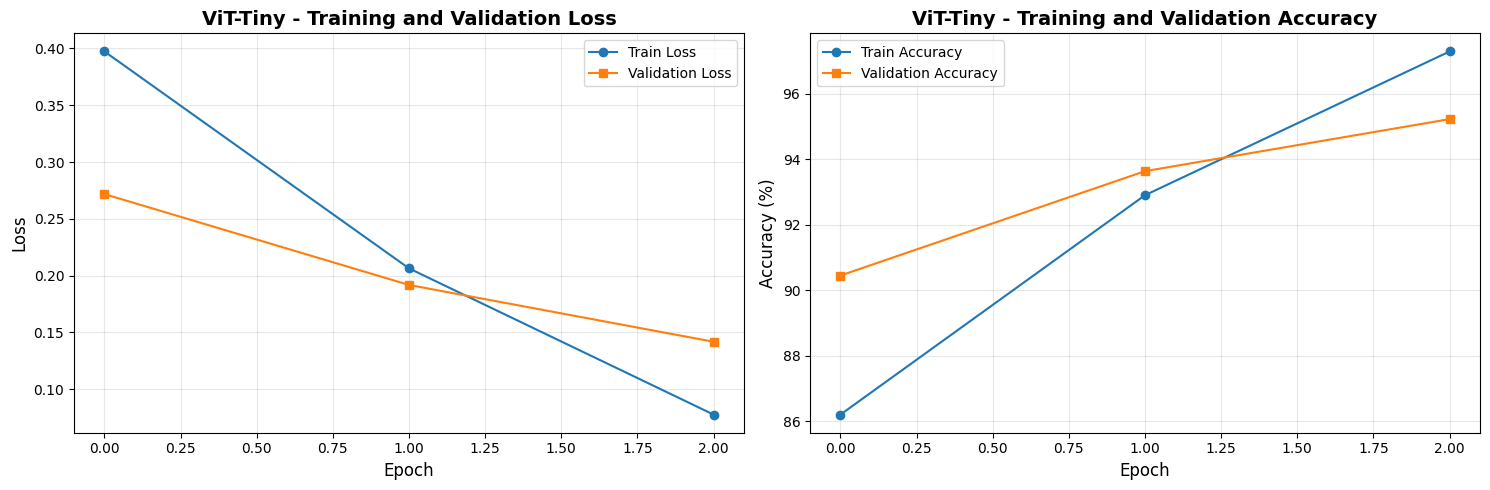


Evaluating ViT-Tiny on test set...


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]


Measuring inference time for ViT-Tiny...


Measuring inference time:   0%|          | 0/1250 [00:00<?, ?it/s]


ViT-Tiny - Test Results
Accuracy: 95.64%
Precision (macro): 95.72%
Recall (macro): 95.64%
F1-Score (macro): 95.66%

Inference Time:
  Avg time per image: 69.36 ± 6.50 ms
  Throughput: 14.42 images/sec


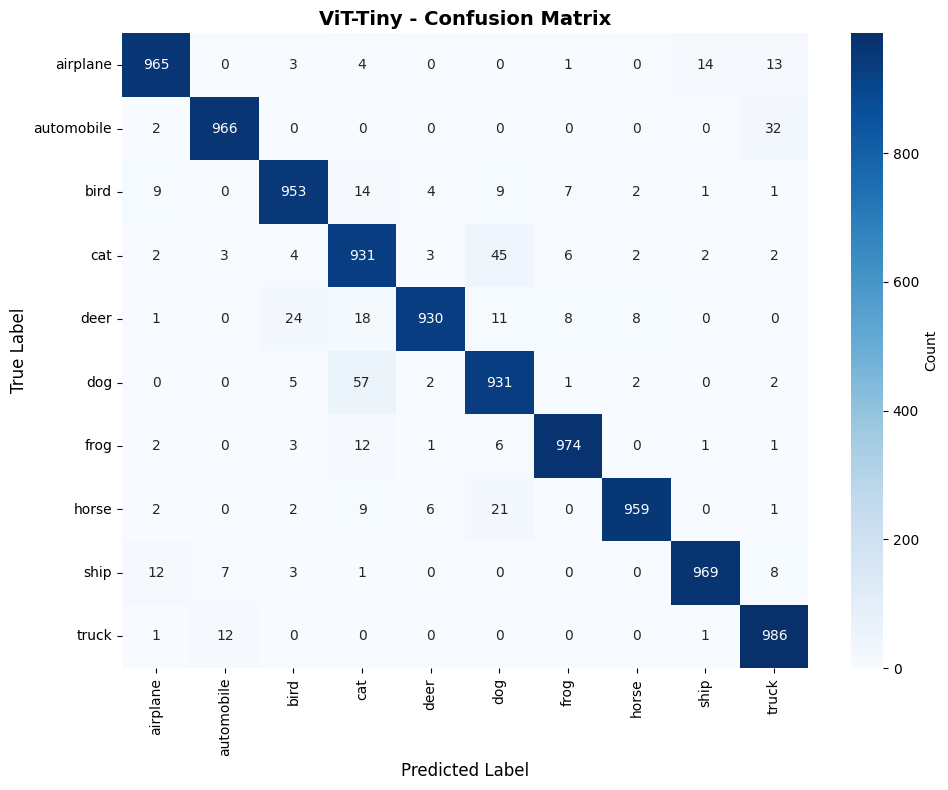

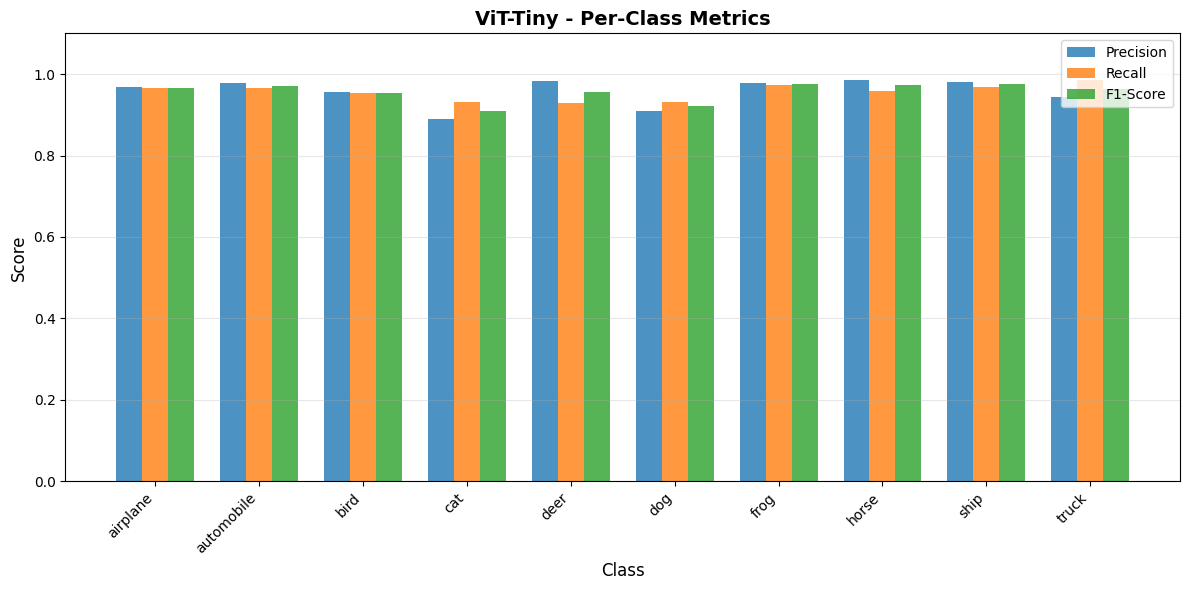


Model saved: ViT-Tiny_model.pth

Processing Model: DeiT-Tiny

Processing Model: DeiT-Tiny


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


Model Parameters:
  Total: 5,526,346
  Trainable: 5,526,346
  Non-trainable: 0
  Model size: 21.08 MB

Training DeiT-Tiny


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.4385, Train Acc: 85.21%
  Val Loss: 0.3520, Val Acc: 87.85%

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.2295, Train Acc: 92.30%
  Val Loss: 0.2330, Val Acc: 92.01%

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.0950, Train Acc: 96.79%
  Val Loss: 0.1600, Val Acc: 94.63%


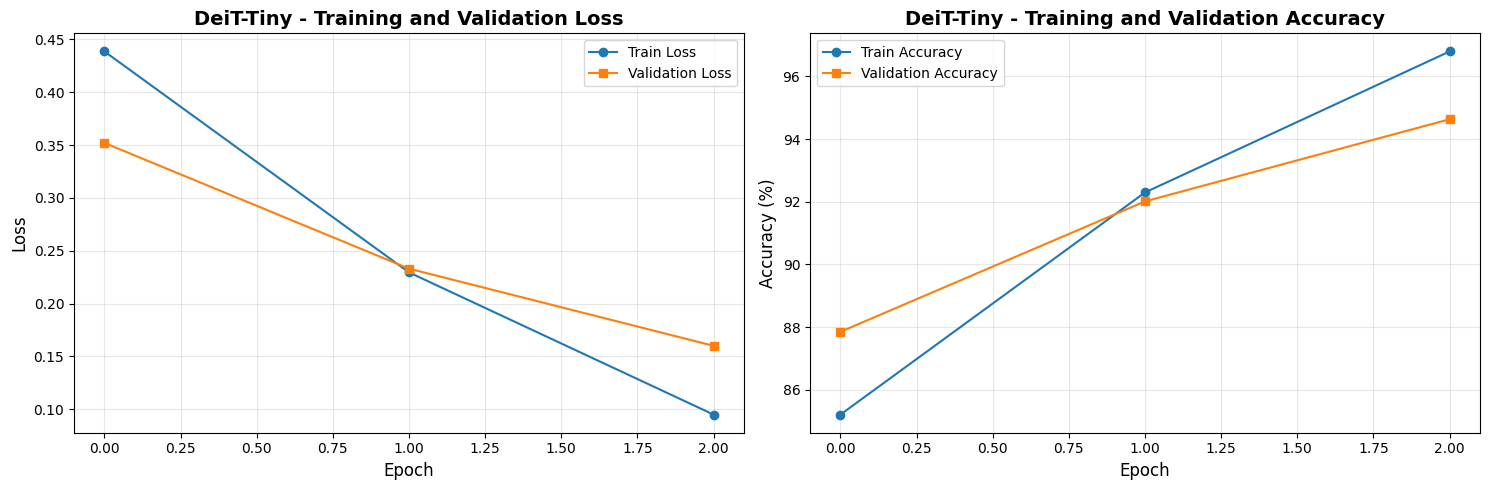


Evaluating DeiT-Tiny on test set...


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]


Measuring inference time for DeiT-Tiny...


Measuring inference time:   0%|          | 0/1250 [00:00<?, ?it/s]


DeiT-Tiny - Test Results
Accuracy: 94.98%
Precision (macro): 95.04%
Recall (macro): 94.98%
F1-Score (macro): 94.99%

Inference Time:
  Avg time per image: 14.47 ± 0.86 ms
  Throughput: 69.10 images/sec


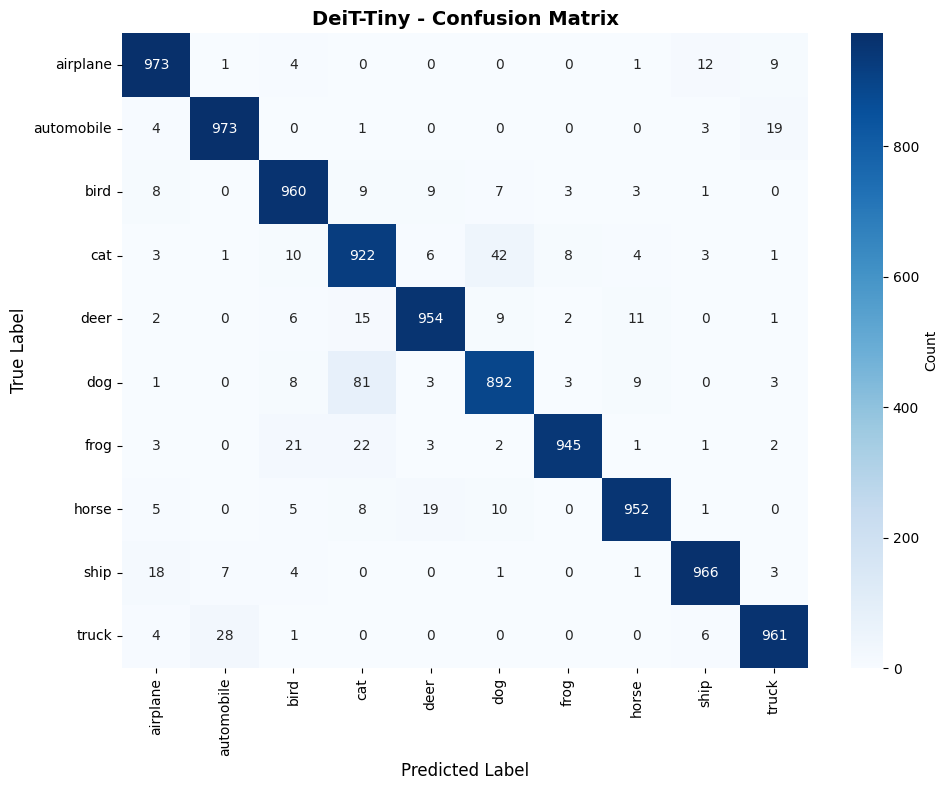

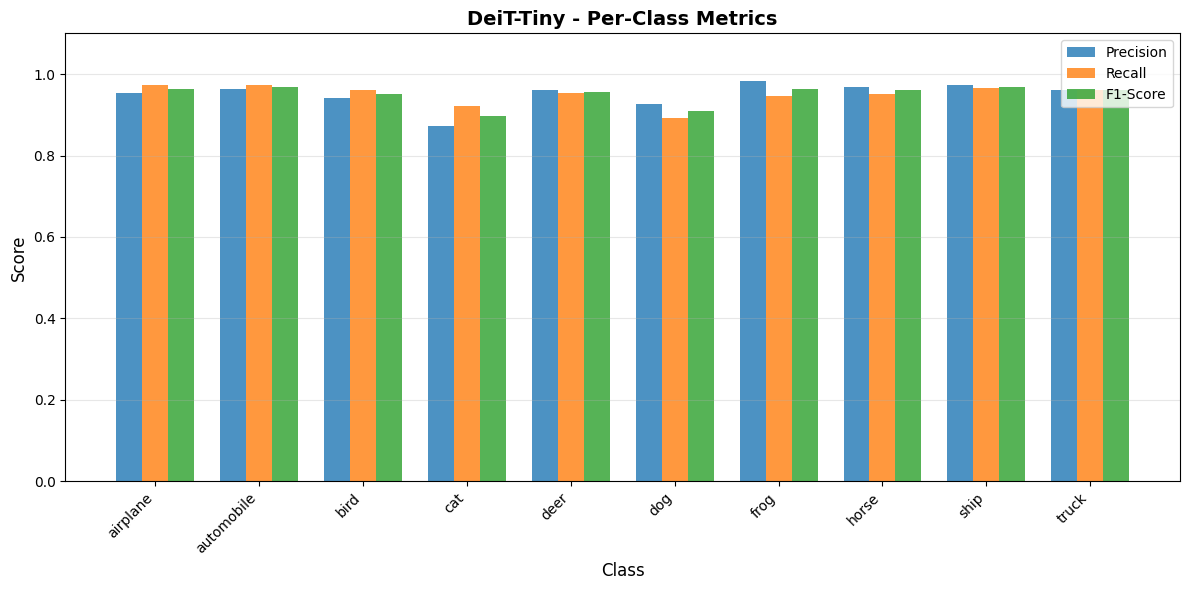


Model saved: DeiT-Tiny_model.pth

Processing Model: Swin-Tiny

Processing Model: Swin-Tiny

Model Parameters:
  Total: 27,527,044
  Trainable: 27,527,044
  Non-trainable: 0
  Model size: 105.01 MB

Training Swin-Tiny


Epoch 1/3
----------------------------------------

Model Parameters:
  Total: 27,527,044
  Trainable: 27,527,044
  Non-trainable: 0
  Model size: 105.01 MB

Training Swin-Tiny


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.3653, Train Acc: 87.90%
  Val Loss: 0.2262, Val Acc: 92.57%

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.1929, Train Acc: 93.63%
  Val Loss: 0.1987, Val Acc: 93.23%

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.0776, Train Acc: 97.44%
  Val Loss: 0.1153, Val Acc: 96.38%


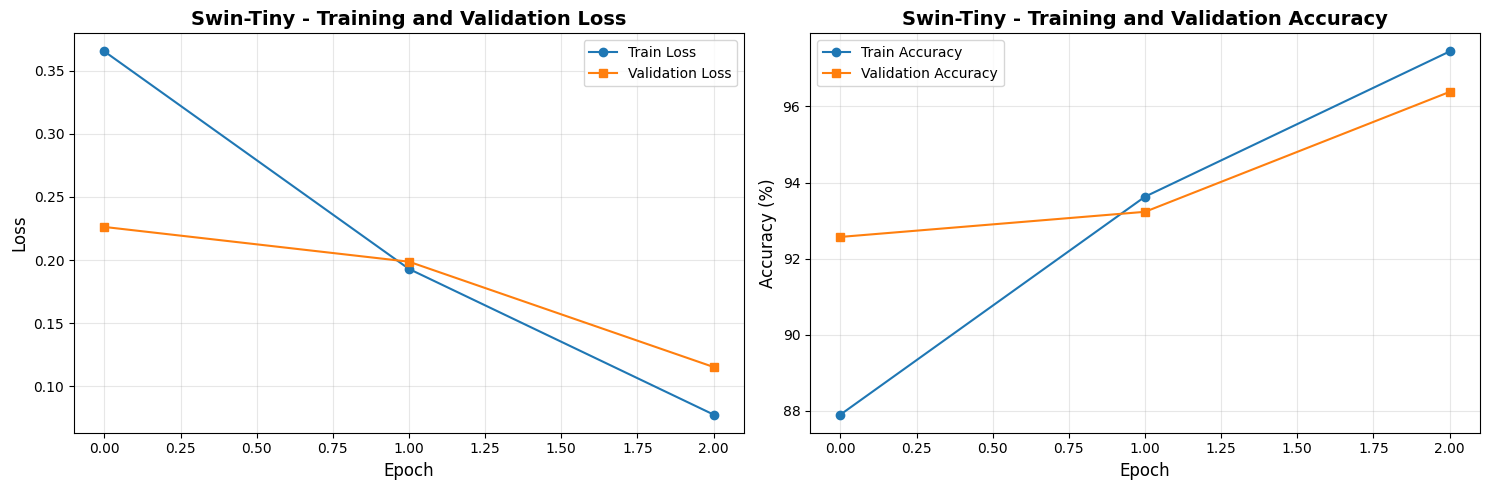


Evaluating Swin-Tiny on test set...


Evaluating:   0%|          | 0/1250 [00:00<?, ?it/s]


Measuring inference time for Swin-Tiny...


Measuring inference time:   0%|          | 0/1250 [00:00<?, ?it/s]


Swin-Tiny - Test Results
Accuracy: 96.25%
Precision (macro): 96.30%
Recall (macro): 96.25%
F1-Score (macro): 96.25%

Inference Time:
  Avg time per image: 81.29 ± 5.66 ms
  Throughput: 12.30 images/sec


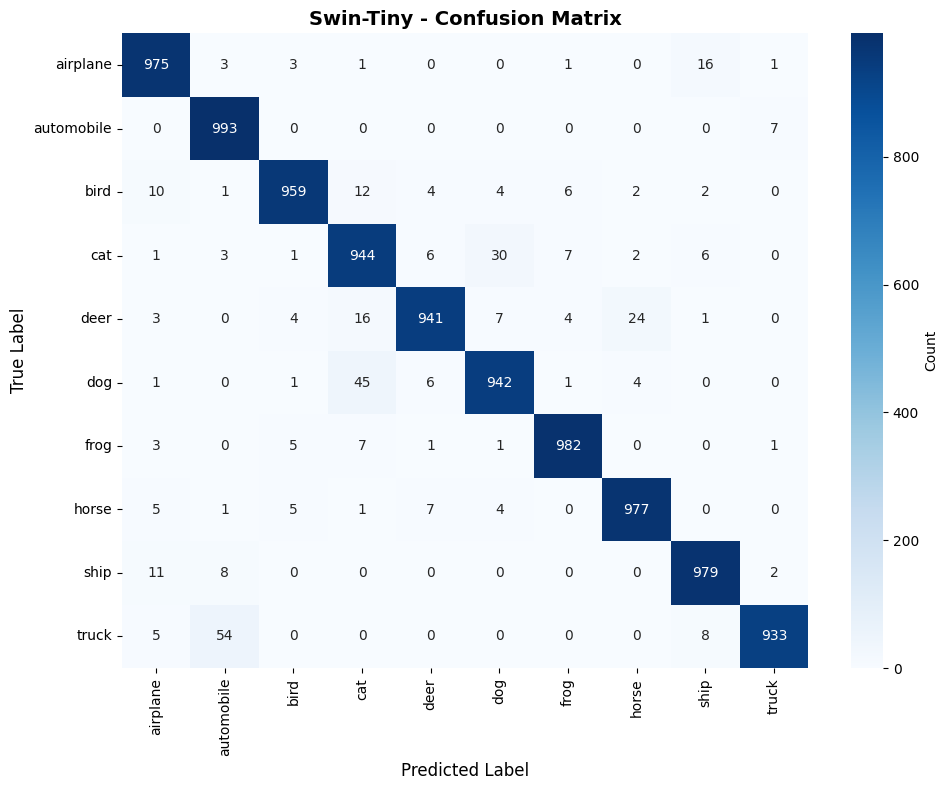

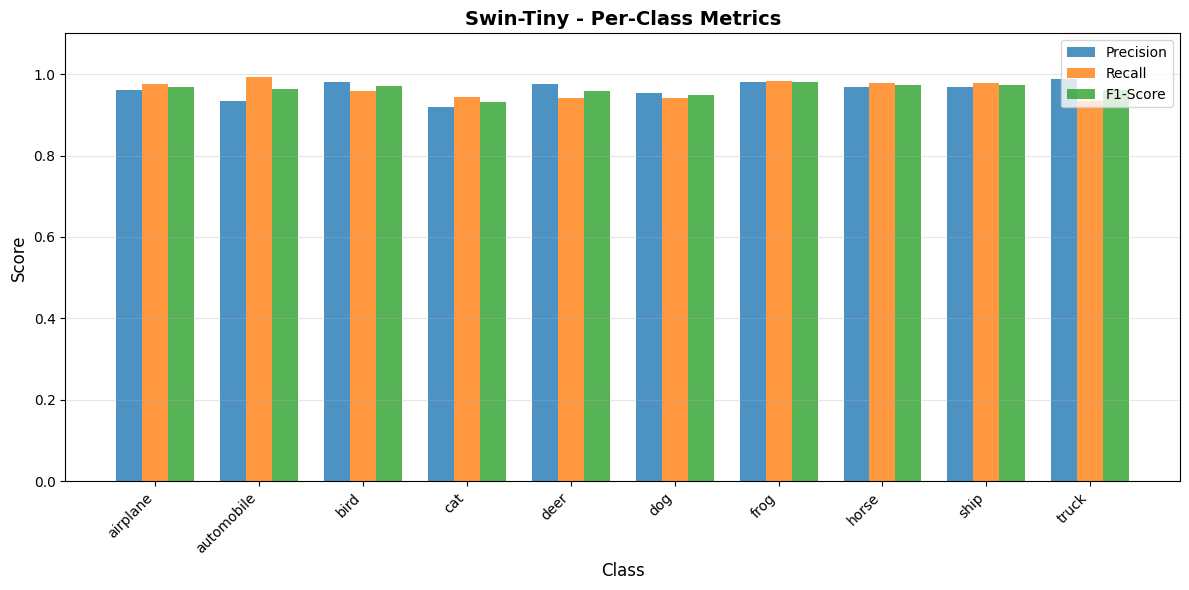


Model saved: Swin-Tiny_model.pth

Training completed!
Successfully trained 3 models

Training completed!
Successfully trained 3 models


In [21]:
# Dictionary to store all results
all_results = {}

# Add memory optimization
import gc

for model_display_name, model_timm_name in CONFIG['models'].items():
    print(f"\n{'='*70}")
    print(f"Processing Model: {model_display_name}")
    print(f"{'='*70}")
    
    # Clear memory before each model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    try:
        # Create model
        model = create_model(model_timm_name, num_classes, pretrained=True)
        model = model.to(CONFIG['device'])
        
        # Count parameters
        param_info = count_parameters(model)
        print(f"\nModel Parameters:")
        print(f"  Total: {param_info['total']:,}")
        print(f"  Trainable: {param_info['trainable']:,}")
        print(f"  Non-trainable: {param_info['non_trainable']:,}")
        print(f"  Model size: {param_info['size_mb']:.2f} MB")
        
        # Train model
        model, history = train_model(model, train_loader, val_loader, 
                                     CONFIG['num_epochs'], CONFIG['device'], 
                                     model_display_name)
        
        # Plot training history
        plot_training_history(history, model_display_name)
        
        # Evaluate on test set
        print(f"\nEvaluating {model_display_name} on test set...")
        test_results = evaluate_model(model, test_loader, CONFIG['device'], class_names)
        
        # Measure inference time
        print(f"\nMeasuring inference time for {model_display_name}...")
        inference_results = measure_inference_time(model, test_loader, CONFIG['device'], num_images=50)  # Reduced num_images
        
        # Print results
        print(f"\n{'='*60}")
        print(f"{model_display_name} - Test Results")
        print(f"{'='*60}")
        print(f"Accuracy: {test_results['accuracy']*100:.2f}%")
        print(f"Precision (macro): {test_results['precision_macro']*100:.2f}%")
        print(f"Recall (macro): {test_results['recall_macro']*100:.2f}%")
        print(f"F1-Score (macro): {test_results['f1_macro']*100:.2f}%")
        print(f"\nInference Time:")
        print(f"  Avg time per image: {inference_results['avg_time_ms']:.2f} ± {inference_results['std_time_ms']:.2f} ms")
        print(f"  Throughput: {inference_results['throughput_fps']:.2f} images/sec")
        
        # Plot confusion matrix
        plot_confusion_matrix(test_results['confusion_matrix'], class_names, model_display_name)
        
        # Plot per-class metrics
        plot_per_class_metrics(test_results, class_names, model_display_name)
        
        # Store results
        all_results[model_display_name] = {
            'parameters': param_info,
            'history': history,
            'test_results': test_results,
            'inference': inference_results
        }
        
        # Save model
        torch.save(model.state_dict(), f'{model_display_name}_model.pth')
        print(f"\nModel saved: {model_display_name}_model.pth")
        
    except RuntimeError as e:
        print(f"Error training {model_display_name}: {e}")
        print("Skipping this model due to memory constraints...")
        continue
    except Exception as e:
        print(f"Unexpected error with {model_display_name}: {e}")
        continue
    finally:
        # Clear GPU memory
        if 'model' in locals():
            del model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print(f"\n{'='*70}")
print("Training completed!")
if all_results:
    print(f"Successfully trained {len(all_results)} models")
else:
    print("No models were successfully trained. Please check memory constraints.")
print(f"{'='*70}")

## 9. Comparative Analysis

In [22]:
# Create comparison tables
def create_comparison_tables(all_results):
    """Create comprehensive comparison tables"""
    
    if not all_results:
        print("No results to compare. Please train models first.")
        return None, None, None
    
    # Parameter comparison
    param_data = []
    for model_name, results in all_results.items():
        param_data.append({
            'Model': model_name,
            'Total Parameters': f"{results['parameters']['total']:,}",
            'Trainable Parameters': f"{results['parameters']['trainable']:,}",
            'Non-trainable Parameters': f"{results['parameters']['non_trainable']:,}",
            'Model Size (MB)': f"{results['parameters']['size_mb']:.2f}"
        })
    param_df = pd.DataFrame(param_data)
    
    # Performance comparison
    perf_data = []
    for model_name, results in all_results.items():
        perf_data.append({
            'Model': model_name,
            'Accuracy (%)': f"{results['test_results']['accuracy']*100:.2f}",
            'Precision (%)': f"{results['test_results']['precision_macro']*100:.2f}",
            'Recall (%)': f"{results['test_results']['recall_macro']*100:.2f}",
            'F1-Score (%)': f"{results['test_results']['f1_macro']*100:.2f}"
        })
    perf_df = pd.DataFrame(perf_data)
    
    # Inference time comparison
    inference_data = []
    for model_name, results in all_results.items():
        inference_data.append({
            'Model': model_name,
            'Avg Time per Image (ms)': f"{results['inference']['avg_time_ms']:.2f}",
            'Std Time (ms)': f"{results['inference']['std_time_ms']:.2f}",
            'Throughput (images/sec)': f"{results['inference']['throughput_fps']:.2f}"
        })
    inference_df = pd.DataFrame(inference_data)
    
    return param_df, perf_df, inference_df

if all_results:
    param_df, perf_df, inference_df = create_comparison_tables(all_results)
    
    if param_df is not None:
        print("\n" + "="*70)
        print("PARAMETER COMPARISON")
        print("="*70)
        print(param_df.to_string(index=False))

        print("\n" + "="*70)
        print("PERFORMANCE COMPARISON")
        print("="*70)
        print(perf_df.to_string(index=False))

        print("\n" + "="*70)
        print("INFERENCE TIME COMPARISON")
        print("="*70)
        print(inference_df.to_string(index=False))

        # Save tables to CSV
        param_df.to_csv('figure/parameter_comparison.csv', index=False)
        perf_df.to_csv('figure/performance_comparison.csv', index=False)
        inference_df.to_csv('figure/inference_comparison.csv', index=False)
        print("\nComparison tables saved to CSV files in 'figure' folder")
else:
    print("No models to compare. Please train models first.")


PARAMETER COMPARISON
    Model Total Parameters Trainable Parameters Non-trainable Parameters Model Size (MB)
 ViT-Tiny        5,526,346            5,526,346                        0           21.08
DeiT-Tiny        5,526,346            5,526,346                        0           21.08
Swin-Tiny       27,527,044           27,527,044                        0          105.01

PERFORMANCE COMPARISON
    Model Accuracy (%) Precision (%) Recall (%) F1-Score (%)
 ViT-Tiny        95.64         95.72      95.64        95.66
DeiT-Tiny        94.98         95.04      94.98        94.99
Swin-Tiny        96.25         96.30      96.25        96.25

INFERENCE TIME COMPARISON
    Model Avg Time per Image (ms) Std Time (ms) Throughput (images/sec)
 ViT-Tiny                   69.36          6.50                   14.42
DeiT-Tiny                   14.47          0.86                   69.10
Swin-Tiny                   81.29          5.66                   12.30

Comparison tables saved to CSV files i

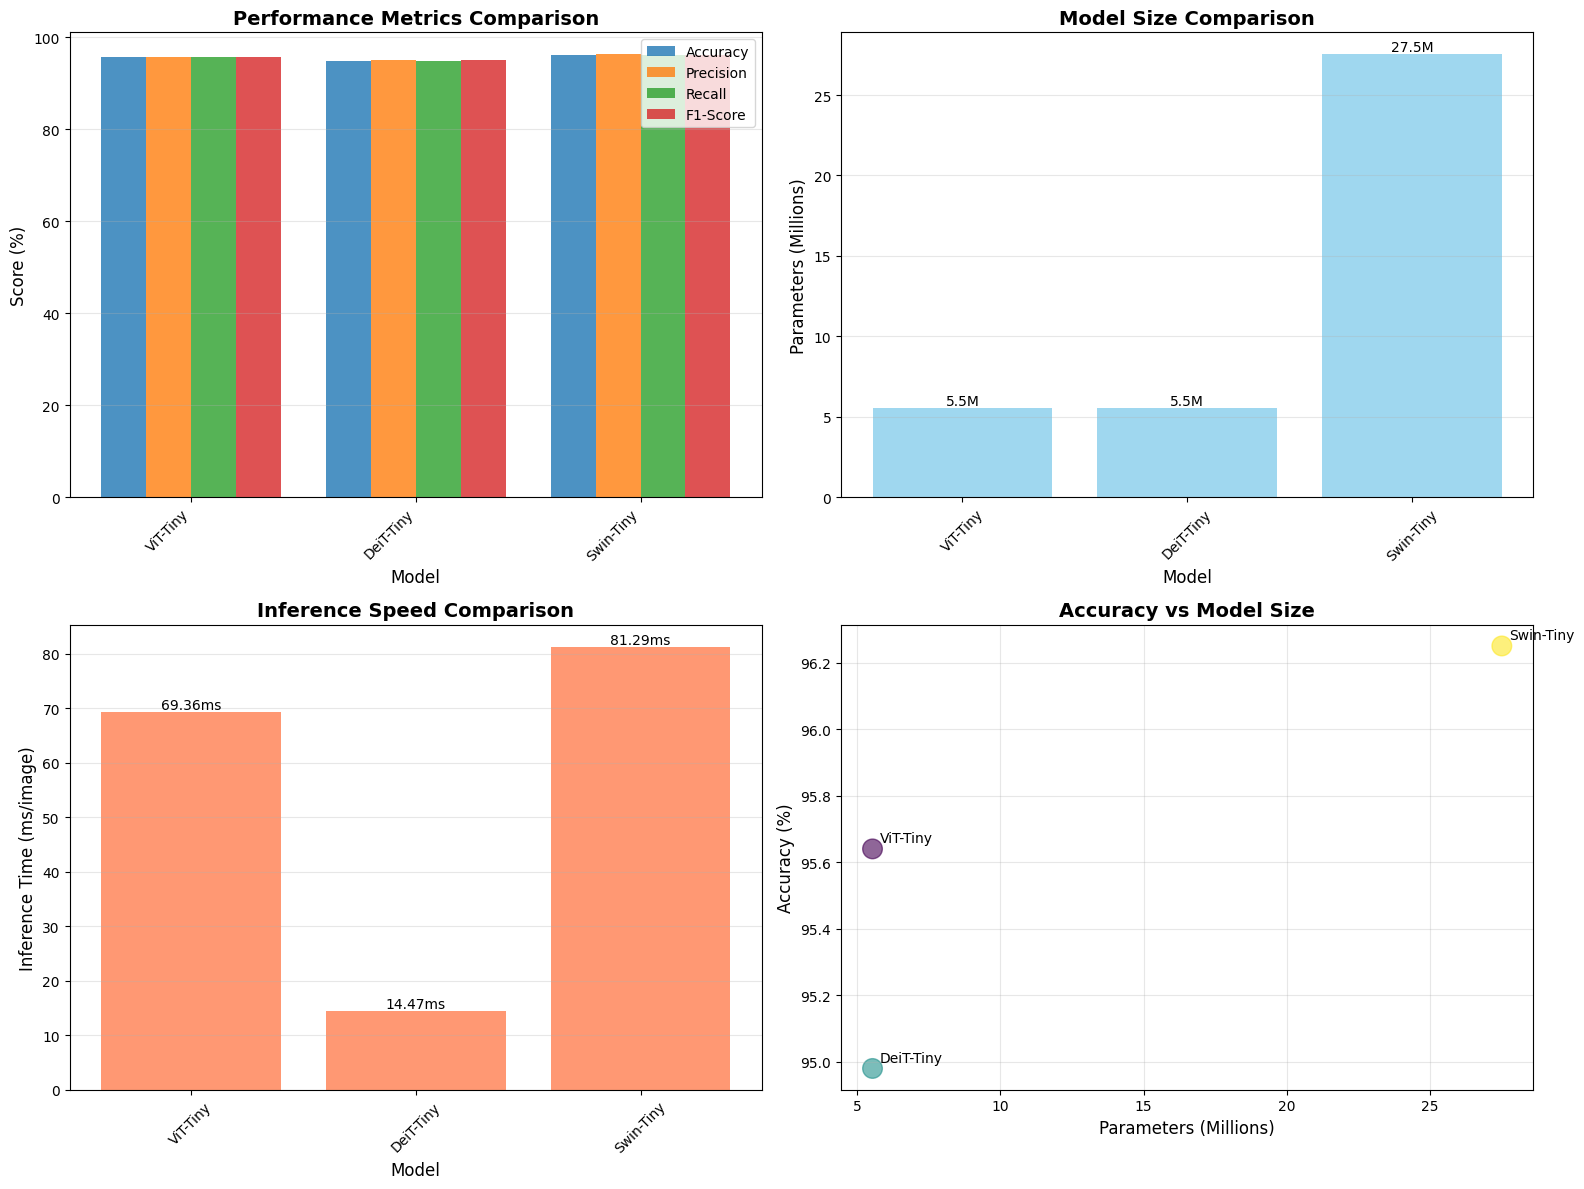

In [23]:
# Visualize comparisons
def plot_model_comparison(all_results):
    """Create comparison visualizations"""
    
    models = list(all_results.keys())
    
    # Extract metrics
    accuracies = [all_results[m]['test_results']['accuracy']*100 for m in models]
    precisions = [all_results[m]['test_results']['precision_macro']*100 for m in models]
    recalls = [all_results[m]['test_results']['recall_macro']*100 for m in models]
    f1_scores = [all_results[m]['test_results']['f1_macro']*100 for m in models]
    params = [all_results[m]['parameters']['total']/1e6 for m in models]  # in millions
    inference_times = [all_results[m]['inference']['avg_time_ms'] for m in models]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Performance metrics comparison
    ax1 = axes[0, 0]
    x = np.arange(len(models))
    width = 0.2
    ax1.bar(x - 1.5*width, accuracies, width, label='Accuracy', alpha=0.8)
    ax1.bar(x - 0.5*width, precisions, width, label='Precision', alpha=0.8)
    ax1.bar(x + 0.5*width, recalls, width, label='Recall', alpha=0.8)
    ax1.bar(x + 1.5*width, f1_scores, width, label='F1-Score', alpha=0.8)
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Score (%)', fontsize=12)
    ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Parameter count comparison
    ax2 = axes[0, 1]
    bars = ax2.bar(models, params, alpha=0.8, color='skyblue')
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('Parameters (Millions)', fontsize=12)
    ax2.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}M', ha='center', va='bottom')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Inference time comparison
    ax3 = axes[1, 0]
    bars = ax3.bar(models, inference_times, alpha=0.8, color='coral')
    ax3.set_xlabel('Model', fontsize=12)
    ax3.set_ylabel('Inference Time (ms/image)', fontsize=12)
    ax3.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms', ha='center', va='bottom')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Accuracy vs Parameters scatter plot
    ax4 = axes[1, 1]
    scatter = ax4.scatter(params, accuracies, s=200, alpha=0.6, c=range(len(models)), cmap='viridis')
    for i, model in enumerate(models):
        ax4.annotate(model, (params[i], accuracies[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    ax4.set_xlabel('Parameters (Millions)', fontsize=12)
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figure/model_comparison_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison(all_results)

## 10. Save Complete Results

In [24]:
# Save all results to JSON
def save_results_to_json(all_results, filename='experiment_results.json'):
    """Save all results to JSON file"""
    results_to_save = {}
    
    for model_name, results in all_results.items():
        results_to_save[model_name] = {
            'parameters': results['parameters'],
            'final_train_loss': float(results['history']['train_loss'][-1]),
            'final_train_acc': float(results['history']['train_acc'][-1]),
            'final_val_loss': float(results['history']['val_loss'][-1]),
            'final_val_acc': float(results['history']['val_acc'][-1]),
            'test_accuracy': float(results['test_results']['accuracy']),
            'test_precision': float(results['test_results']['precision_macro']),
            'test_recall': float(results['test_results']['recall_macro']),
            'test_f1': float(results['test_results']['f1_macro']),
            'inference_time_ms': float(results['inference']['avg_time_ms']),
            'throughput_fps': float(results['inference']['throughput_fps'])
        }
    
    with open(filename, 'w') as f:
        json.dump(results_to_save, f, indent=4)
    
    print(f"Results saved to {filename}")

save_results_to_json(all_results)

print("\n" + "="*70)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*70)

Results saved to experiment_results.json

EXPERIMENT COMPLETED SUCCESSFULLY!


## 11. Generate Summary Report

In [25]:
# Generate text summary for report
def generate_summary_report(all_results):
    """Generate a summary report"""
    
    report = []
    report.append("="*70)
    report.append("VISION TRANSFORMER COMPARISON - SUMMARY REPORT")
    report.append("="*70)
    report.append("")
    
    # Hardware info
    report.append("Hardware Configuration:")
    report.append(f"  Device: {CONFIG['device']}")
    if torch.cuda.is_available():
        report.append(f"  GPU: {torch.cuda.get_device_name(0)}")
    report.append("")
    
    # Dataset info
    report.append("Dataset Information:")
    report.append(f"  Number of classes: {num_classes}")
    report.append(f"  Training samples: {len(train_dataset)}")
    report.append(f"  Validation samples: {len(val_dataset)}")
    report.append(f"  Test samples: {len(test_dataset)}")
    report.append("")
    
    # Model comparison
    report.append("Model Comparison Summary:")
    report.append("")
    
    for model_name, results in all_results.items():
        report.append(f"{model_name}:")
        report.append(f"  Parameters: {results['parameters']['total']:,} ({results['parameters']['size_mb']:.2f} MB)")
        report.append(f"  Test Accuracy: {results['test_results']['accuracy']*100:.2f}%")
        report.append(f"  Test F1-Score: {results['test_results']['f1_macro']*100:.2f}%")
        report.append(f"  Inference Time: {results['inference']['avg_time_ms']:.2f} ms/image")
        report.append(f"  Throughput: {results['inference']['throughput_fps']:.2f} images/sec")
        report.append("")
    
    # Best model for different use cases
    report.append("Recommendations:")
    report.append("")
    
    # Best accuracy
    best_acc_model = max(all_results.items(), 
                        key=lambda x: x[1]['test_results']['accuracy'])
    report.append(f"Best Accuracy: {best_acc_model[0]} ({best_acc_model[1]['test_results']['accuracy']*100:.2f}%)")
    
    # Fastest inference
    fastest_model = min(all_results.items(), 
                       key=lambda x: x[1]['inference']['avg_time_ms'])
    report.append(f"Fastest Inference: {fastest_model[0]} ({fastest_model[1]['inference']['avg_time_ms']:.2f} ms)")
    
    # Smallest model
    smallest_model = min(all_results.items(), 
                        key=lambda x: x[1]['parameters']['total'])
    report.append(f"Smallest Model: {smallest_model[0]} ({smallest_model[1]['parameters']['total']:,} params)")
    
    report.append("")
    report.append("="*70)
    
    report_text = "\n".join(report)
    
    # Save to file
    with open('figure/summary_report.txt', 'w') as f:
        f.write(report_text)
    
    print(report_text)
    print("\nSummary report saved to 'figure/summary_report.txt'")

generate_summary_report(all_results)

VISION TRANSFORMER COMPARISON - SUMMARY REPORT

Hardware Configuration:
  Device: cpu

Dataset Information:
  Number of classes: 10
  Training samples: 40000
  Validation samples: 10000
  Test samples: 10000

Model Comparison Summary:

ViT-Tiny:
  Parameters: 5,526,346 (21.08 MB)
  Test Accuracy: 95.64%
  Test F1-Score: 95.66%
  Inference Time: 69.36 ms/image
  Throughput: 14.42 images/sec

DeiT-Tiny:
  Parameters: 5,526,346 (21.08 MB)
  Test Accuracy: 94.98%
  Test F1-Score: 94.99%
  Inference Time: 14.47 ms/image
  Throughput: 69.10 images/sec

Swin-Tiny:
  Parameters: 27,527,044 (105.01 MB)
  Test Accuracy: 96.25%
  Test F1-Score: 96.25%
  Inference Time: 81.29 ms/image
  Throughput: 12.30 images/sec

Recommendations:

Best Accuracy: Swin-Tiny (96.25%)
Fastest Inference: DeiT-Tiny (14.47 ms)
Smallest Model: ViT-Tiny (5,526,346 params)


Summary report saved to 'figure/summary_report.txt'


## 12. Additional Analysis (Optional)

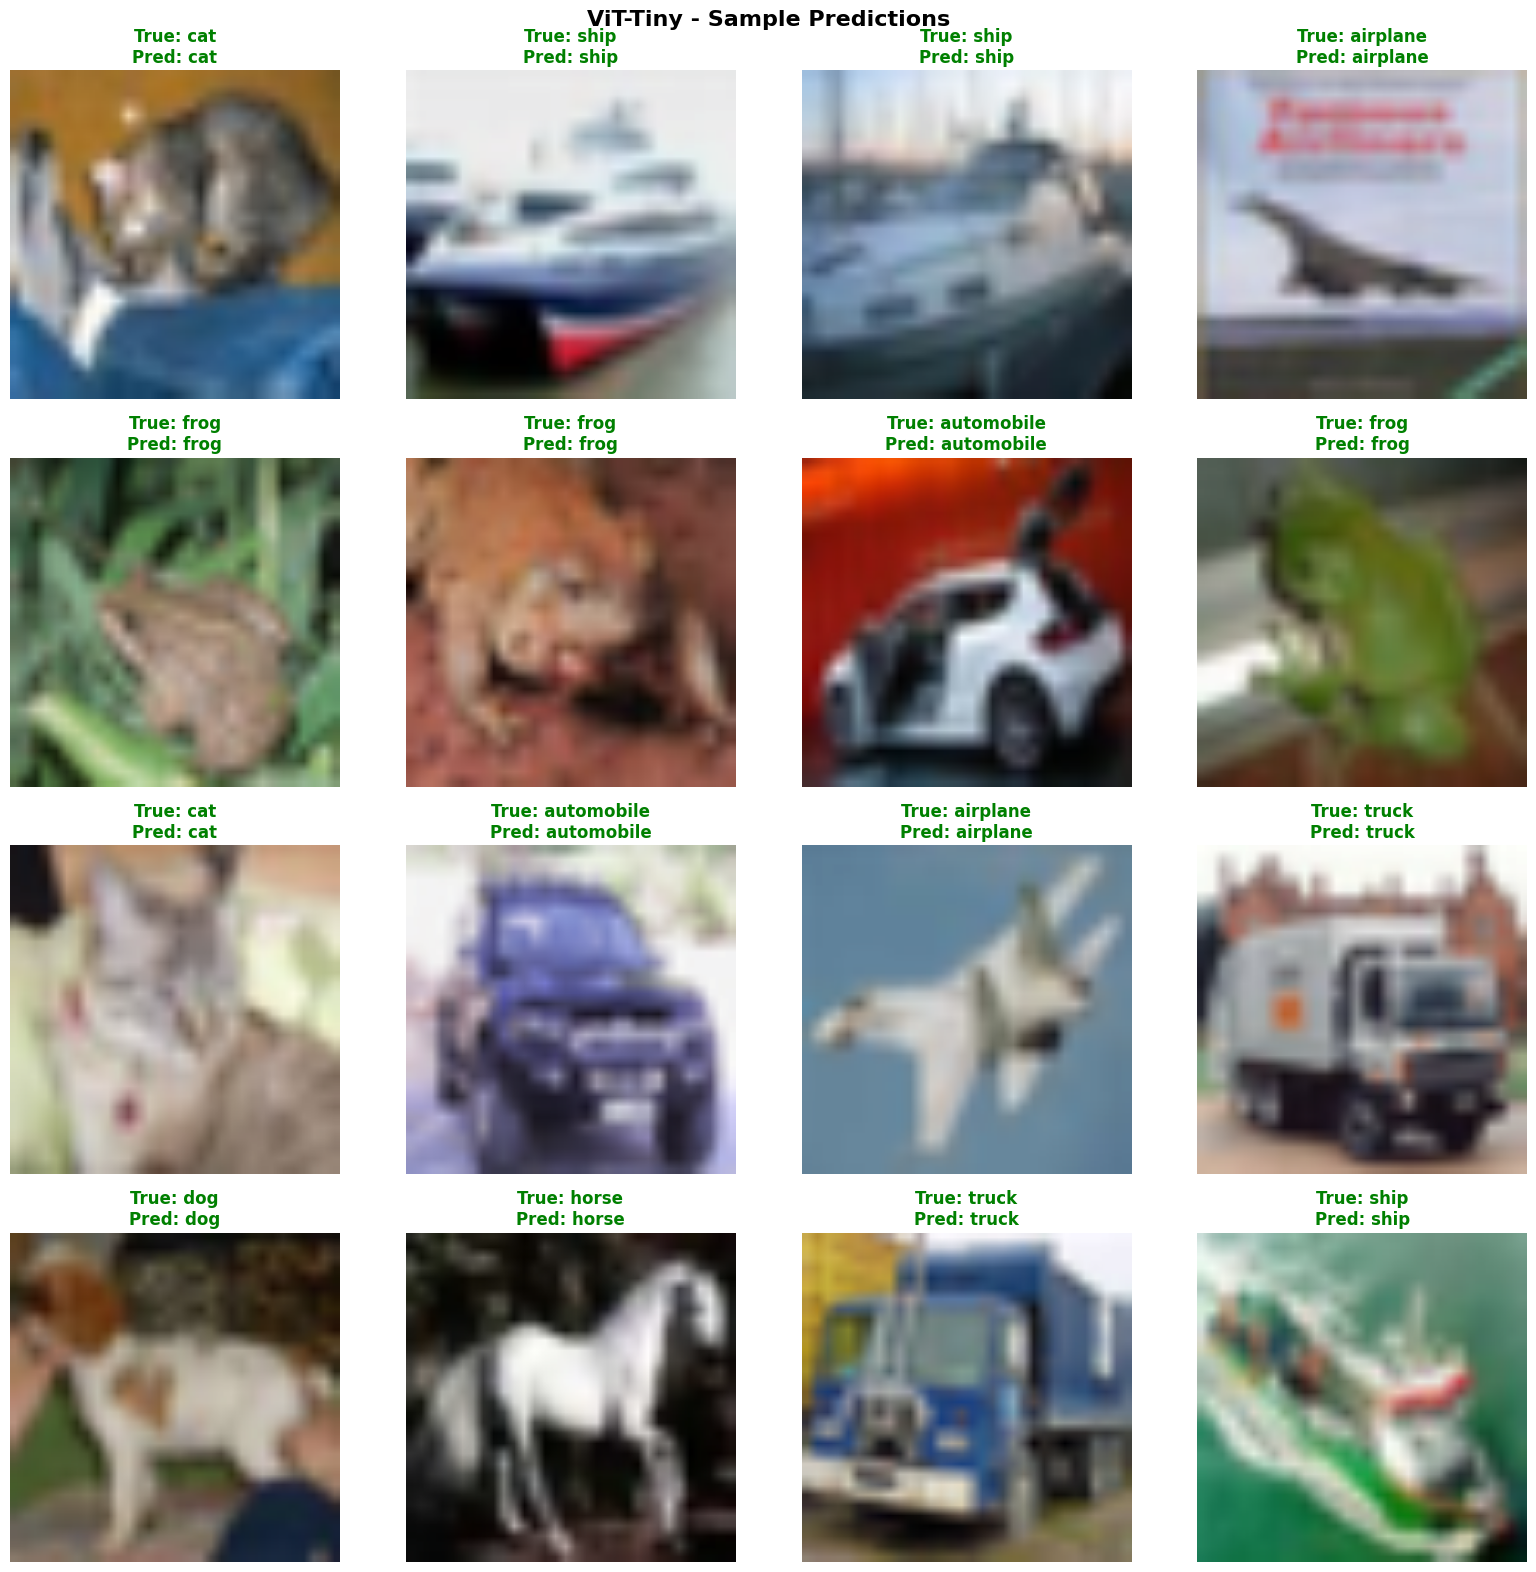

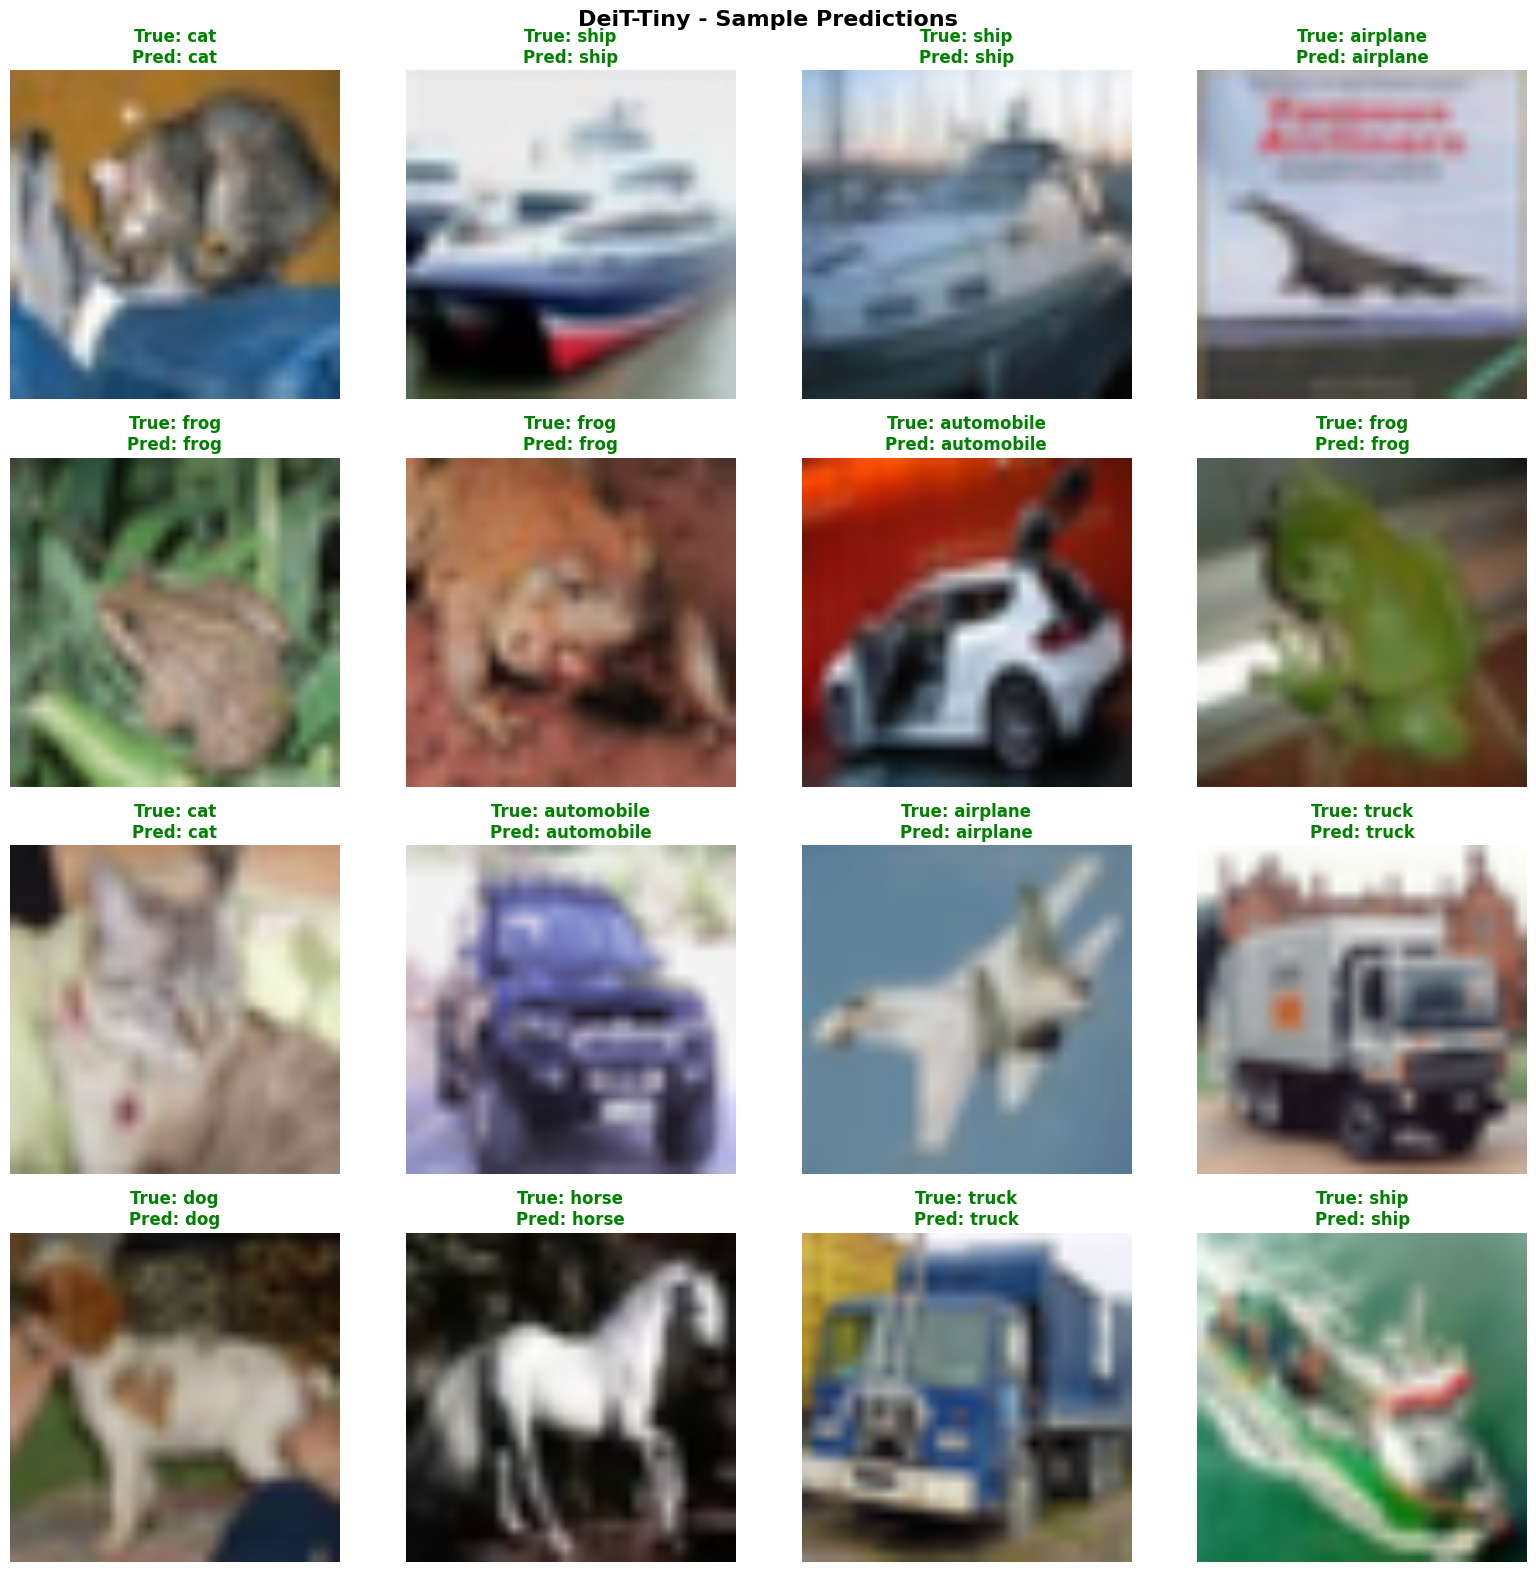

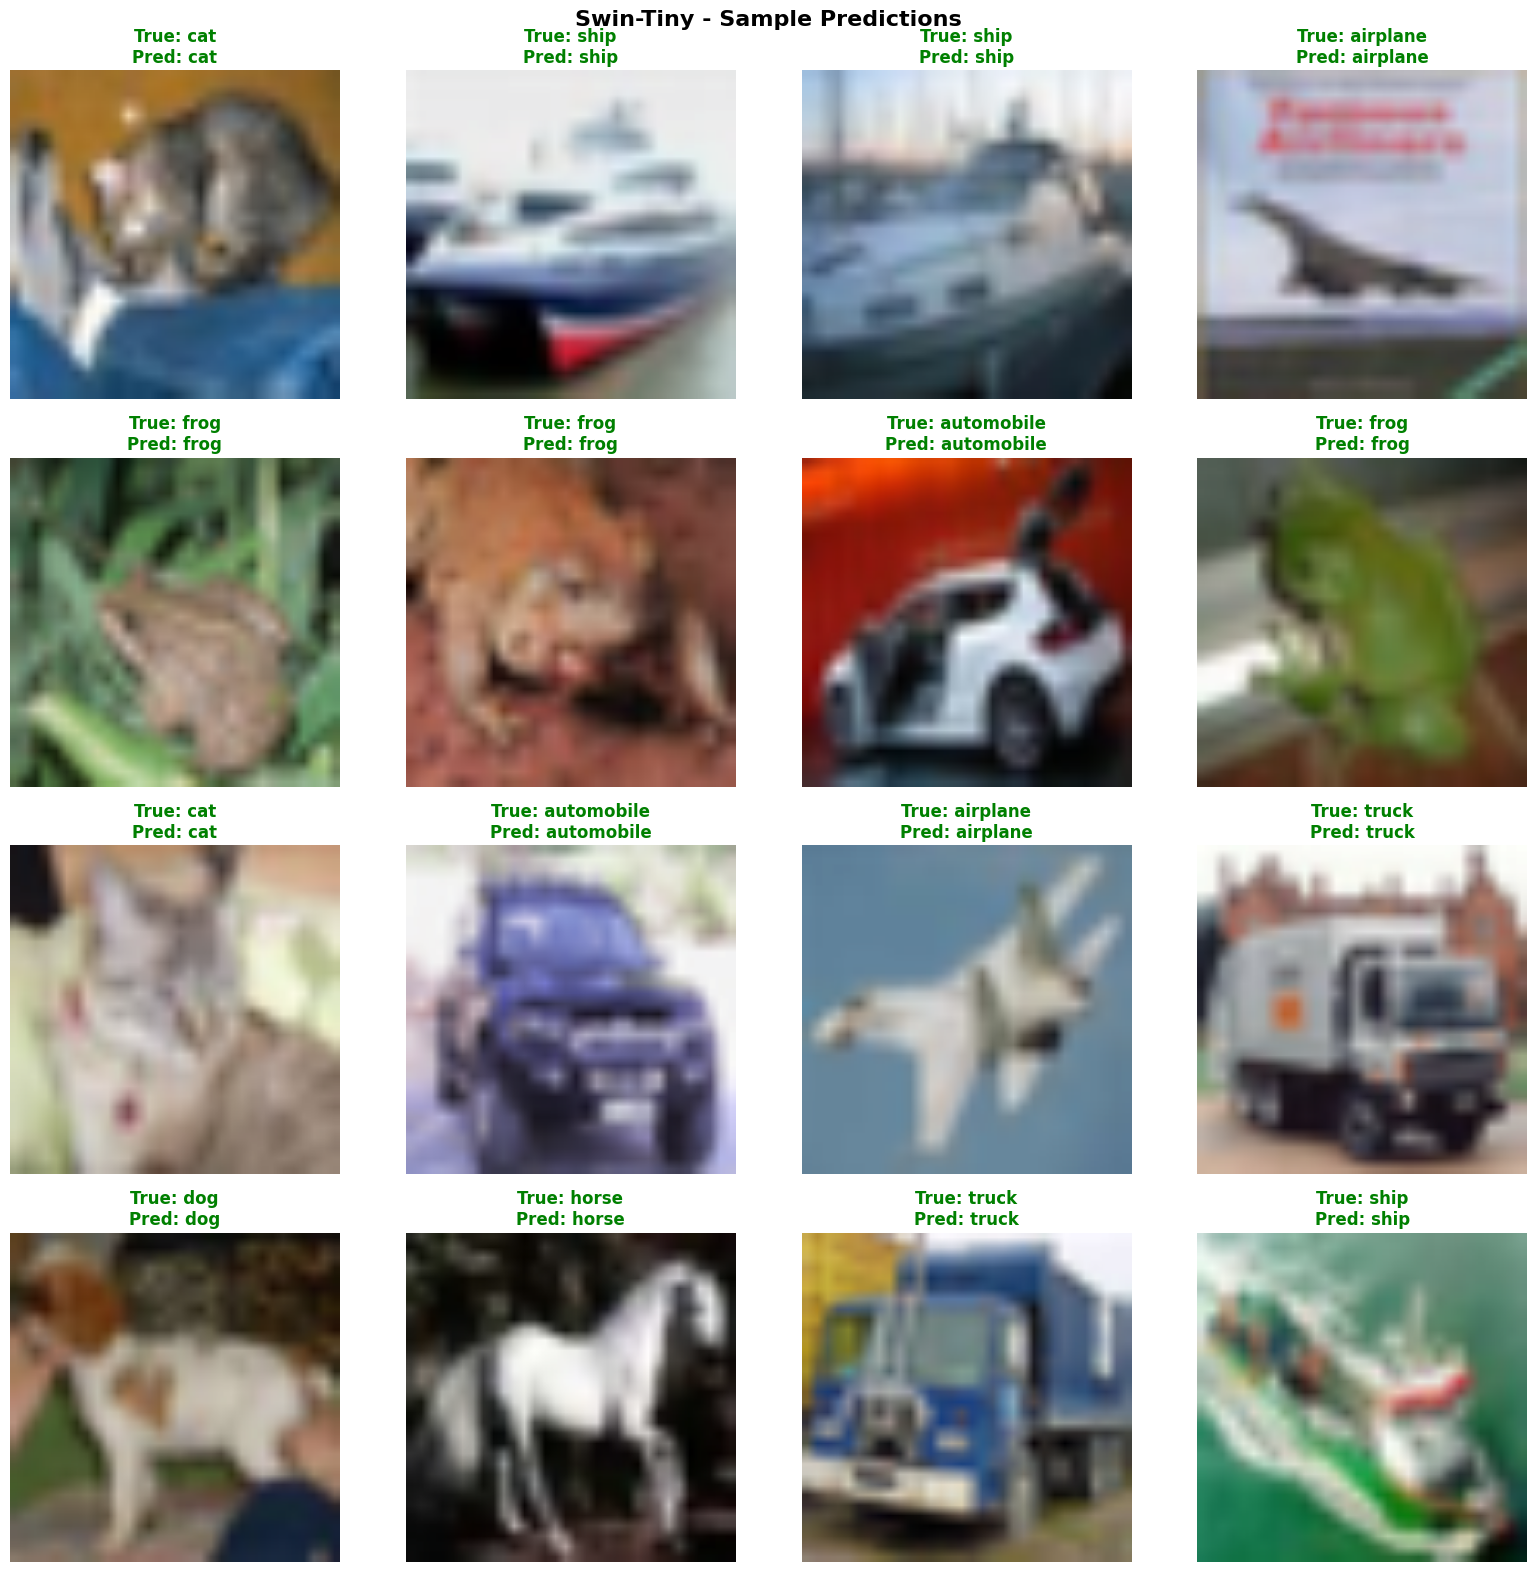

In [31]:
# Example predictions visualization
def visualize_predictions(model, dataloader, device, class_names, model_name, num_images=16):
    """Visualize model predictions"""
    model.eval()
    
    images_shown = 0
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            if images_shown >= num_images:
                break
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            for i in range(min(inputs.size(0), num_images - images_shown)):
                # Denormalize image
                img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                true_label = class_names[labels[i]]
                pred_label = class_names[predicted[i]]
                
                color = 'green' if true_label == pred_label else 'red'
                
                axes[images_shown].imshow(img)
                axes[images_shown].set_title(f'True: {true_label}\nPred: {pred_label}', 
                                            color=color, fontweight='bold')
                axes[images_shown].axis('off')
                
                images_shown += 1
                
                if images_shown >= num_images:
                    break
    
    plt.suptitle(f'{model_name} - Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'figure/{model_name}_sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()


for model_name in CONFIG['models'].keys():
    model = create_model(CONFIG['models'][model_name], num_classes, pretrained=False)
    model.load_state_dict(torch.load(f'{model_name}_model.pth'))
    model = model.to(CONFIG['device'])
    visualize_predictions(model, test_loader, CONFIG['device'], class_names, model_name)